# Validation and Test 

Collab link: https://colab.research.google.com/notebooks/mlcc/validation.ipynb

In [0]:
from __future__ import print_function
 
import math

from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
%tensorflow_version 1.x
import tensorflow as tf
from tensorflow.python.data import Dataset

tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format

chdf = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_train.csv", sep=",")

print(chdf.index)
chdf = chdf.reindex(np.random.permutation(chdf.index))  ## this is very important especially to split the data into training, validation and test sets!!!!!

RangeIndex(start=0, stop=17000, step=1)


Processing the features and the labels:

In [0]:
# Preprocessing the features:
def preprocess_features(df):
  """Prepares input features from California housing data set.

  Args:
    california_housing_dataframe: A Pandas DataFrame expected to contain data
      from the California housing data set.
  Returns:
    A DataFrame that contains the features to be used for the model, including
    synthetic features.
  """
  selected_features = df[
    ["latitude",
     "longitude",
     "housing_median_age",
     "total_rooms",
     "total_bedrooms",
     "population",
     "households",
     "median_income"]]

  # print mean for each pd column:
  # print(selected_features.mean())
  # print(selected_features.std())

  processed_features = selected_features.copy()
  # Create a synthetic feature:
  processed_features['rooms_per_person'] = df['total_rooms'] / df['population']

  # Scaling the features:
  # processed_features -= processed_features.mean()
  # processed_features /= processed_features.std()

  return processed_features


# Preprocessing the labels:
def preprocess_targets(df):
  """Prepares target features (i.e., labels) from California housing data set.

  Args:
    california_housing_dataframe: A Pandas DataFrame expected to contain data
      from the California housing data set.
  Returns:
    A DataFrame that contains the target feature.
  """
  output_targets = pd.DataFrame()  # just to initialise the pd dataframe
  # Scale the target to be in units of thousands of dollars.
  output_targets['median_house_value'] = df['median_house_value'] / 1000.0

  return output_targets


pchdf = preprocess_features(chdf)
ochdf = preprocess_targets(chdf)

print(pchdf.head())
print(ochdf.head())

       latitude  longitude  ...  median_income  rooms_per_person
11886      38.0     -121.3  ...            5.9               2.9
8770       34.2     -118.6  ...            7.3               2.1
11119      37.2     -121.0  ...            3.2               2.4
13800      37.3     -122.0  ...            6.3               2.1
11027      36.5     -121.0  ...            3.2               2.7

[5 rows x 9 columns]
       median_house_value
11886               189.9
8770                333.7
11119                97.6
13800               344.2
11027               225.0


Task 1: Assigning the Training set and the Validation set  and  Examining the Data

In [0]:
# Setting the training set size
train_val_split = 0.8
m_train = int(train_val_split*pchdf.shape[0])
# Setting the validation set size:
m_val = pchdf.shape[0] - m_train

# Splitting DF into training and validation sets:
training_examples = pchdf.head(m_train)
print(training_examples.describe())

training_targets = ochdf.head(m_train)
print(training_targets.describe())

validation_examples = pchdf.tail(m_val)  # we take the last examples using the tail
print(validation_examples.describe())

validation_targets = ochdf.tail(m_val)
print(validation_targets.describe())

       latitude  longitude  ...  median_income  rooms_per_person
count   13600.0    13600.0  ...        13600.0           13600.0
mean       35.6     -119.6  ...            3.9               2.0
std         2.1        2.0  ...            1.9               1.2
min        32.5     -124.3  ...            0.5               0.0
25%        33.9     -121.8  ...            2.6               1.5
50%        34.2     -118.5  ...            3.5               1.9
75%        37.7     -118.0  ...            4.8               2.3
max        42.0     -114.5  ...           15.0              55.2

[8 rows x 9 columns]
       median_house_value
count             13600.0
mean                207.6
std                 116.1
min                  15.0
25%                 119.6
50%                 181.1
75%                 265.7
max                 500.0
       latitude  longitude  ...  median_income  rooms_per_person
count    3400.0     3400.0  ...         3400.0            3400.0
mean       35.6     -119.5  .

In [0]:
training_examples.head(100)

,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person
11886,38.0,-121.3,21.0,1343.0,183.0,462.0,193.0,5.9,2.9
8770,34.2,-118.6,24.0,5256.0,758.0,2474.0,780.0,7.3,2.1
11119,37.2,-121.0,31.0,1923.0,341.0,806.0,349.0,3.2,2.4
13800,37.3,-122.0,31.0,3080.0,526.0,1493.0,582.0,6.3,2.1
11027,36.5,-121.0,52.0,1691.0,301.0,618.0,239.0,3.2,2.7
...,...,...,...,...,...,...,...,...,...
3313,33.8,-117.9,25.0,1928.0,414.0,961.0,385.0,4.1,2.0
12890,38.0,-121.8,25.0,1710.0,288.0,799.0,259.0,4.8,2.1
69,33.0,-115.5,33.0,2266.0,365.0,952.0,360.0,5.4,2.4
9613,35.4,-119.4,24.0,2585.0,480.0,1442.0,424.0,2.8,1.8



Task 2: Plot Latitude/Longitude vs House value


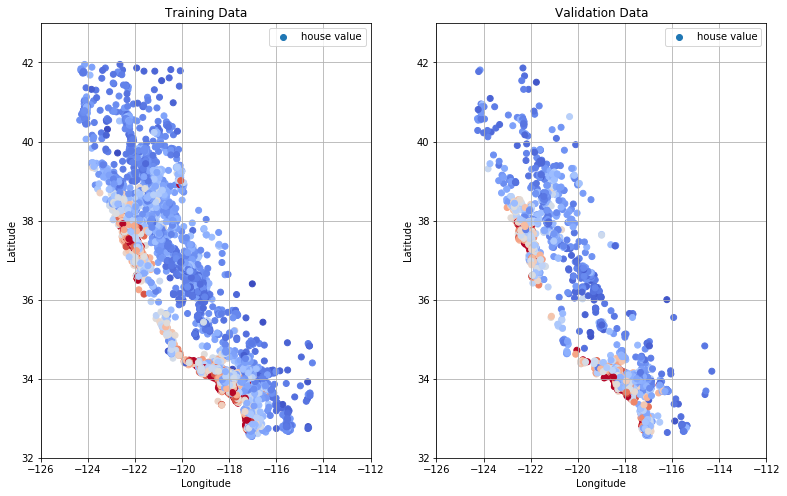

In [0]:
plt.figure(figsize=(13,8))

plt.subplot(1,2,1)
plt.title('Training Data')
plt.ylim([32, 43])
plt.xlim([-126, -112])
plt.scatter(training_examples['longitude'], training_examples['latitude'], cmap='coolwarm', c=training_targets['median_house_value']/training_targets['median_house_value'].max(), label='house value')
plt.grid()
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()

plt.subplot(1,2,2)
plt.title('Validation Data')
plt.ylim([32, 43])
plt.xlim([-126, -112])
plt.scatter(validation_examples['longitude'], validation_examples['latitude'], cmap='coolwarm', c=validation_targets['median_house_value']/validation_targets['median_house_value'].max(), label='house value')
plt.grid()
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()

plt.show()

Task 4: Train and Evaluate the Model

In [0]:
# Input function
def my_input_fn(features, targets, batch_size=1, shuffle=True, num_epochs=None):
    """Trains a linear regression model of multiple features.
  
    Args:
      features: pandas DataFrame of features
      targets: pandas DataFrame of targets
      batch_size: Size of batches to be passed to the model
      shuffle: True or False. Whether to shuffle the data.
      num_epochs: Number of epochs for which data should be repeated. None = repeat indefinitely
    Returns:
      Tuple of (features, labels) for next data batch
    """
    
    # Convert pandas data into a dict of np arrays.
    features = {key:np.array(value) for key,value in dict(features).items()}                                           
 
    # Construct a dataset, and configure batching/repeating.
    ds = Dataset.from_tensor_slices((features,targets)) # warning: 2GB limit
    ds = ds.batch(batch_size).repeat(num_epochs)
    
    # Shuffle the data, if specified.
    if shuffle:
      ds = ds.shuffle(10000)
    
    # Return the next batch of data.
    features, labels = ds.make_one_shot_iterator().get_next()  ## TF 1!!!

    return features, labels

Feature columns:

In [0]:

# Defining feature columns
def construct_feature_columns(input_features):
    """Construct the TensorFlow Feature Columns.

    Args:
      input_features: The names of the numerical input features to use.
    Returns:
      A set of feature columns
    """ 
    # return set([tf.feature_column.numeric_column(my_feature) for my_feature in input_features])  
    return [tf.feature_column.numeric_column(my_feature) for my_feature in input_features]   # set is not needed

# print(construct_feature_columns(training_examples))

# Using multiple features:
Train Model function:

In [0]:
def train_model(
    learning_rate,
    steps,
    batch_size,
    training_examples,
    training_targets,
    validation_examples,
    validation_targets):
  """Trains a linear regression model of multiple features.
  
  In addition to training, this function also prints training progress information,
  as well as a plot of the training and validation loss over time.
  
  Args:
    learning_rate: A `float`, the learning rate.
    steps: A non-zero `int`, the total number of training steps. A training step
      consists of a forward and backward pass using a single batch.
    batch_size: A non-zero `int`, the batch size.
    training_examples: A `DataFrame` containing one or more columns from
      `california_housing_dataframe` to use as input features for training.
    training_targets: A `DataFrame` containing exactly one column from
      `california_housing_dataframe` to use as target for training.
    validation_examples: A `DataFrame` containing one or more columns from
      `california_housing_dataframe` to use as input features for validation.
    validation_targets: A `DataFrame` containing exactly one column from
      `california_housing_dataframe` to use as target for validation.
      
  Returns:
    A `LinearRegressor` object trained on the training data.
  """

  periods = 10
  steps_per_period = steps / periods
  
  # Create a linear regressor object.
  my_optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
  my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
  linear_regressor = tf.estimator.LinearRegressor(
      feature_columns=construct_feature_columns(training_examples),
      optimizer=my_optimizer
  )
  
  # 1. Create input functions.
  training_input_fn = lambda : my_input_fn(training_examples, training_targets, batch_size=batch_size, shuffle=True, num_epochs=None)
  predict_training_input_fn = lambda : my_input_fn(training_examples, training_targets, shuffle=False, num_epochs=1)
  predict_validation_input_fn = lambda : my_input_fn(validation_examples, validation_targets, shuffle=False, num_epochs=1)
  
  # Train the model, but do so inside a loop so that we can periodically assess
  # loss metrics.
  print("Training model...")
  print("RMSE (on training data):")
  training_rmse = []
  validation_rmse = []
  for period in range (0, periods):
    # Train the model, starting from the prior state.
    linear_regressor.train(
        input_fn=training_input_fn,
        steps=steps_per_period,
    )
    # 2. Take a break and compute predictions.
    training_predictions = linear_regressor.predict(input_fn=predict_training_input_fn)
    training_predictions = np.array([item['predictions'][0] for item in training_predictions])
    validation_predictions = linear_regressor.predict(input_fn=predict_validation_input_fn)
    validation_predictions = np.array([item['predictions'][0] for item in validation_predictions])
    
    # Compute training and validation loss.
    training_root_mean_squared_error = math.sqrt( metrics.mean_squared_error(training_predictions, training_targets) )
    validation_root_mean_squared_error = math.sqrt( metrics.mean_squared_error(validation_predictions, validation_targets) )
    # Occasionally print the current loss.
    print("  period %02d : %0.2f" % (period, training_root_mean_squared_error))
    # Add the loss metrics from this period to our list.
    training_rmse.append(training_root_mean_squared_error)
    validation_rmse.append(validation_root_mean_squared_error)
  print("Model training finished.")

  # Output a graph of loss metrics over periods.
  plt.ylabel("RMSE")
  plt.xlabel("Periods")
  plt.title("Root Mean Squared Error vs. Periods")
  plt.tight_layout()
  plt.plot(training_rmse, label="training")
  plt.plot(validation_rmse, label="validation")
  plt.legend()

  return linear_regressor

Training model...
RMSE (on training data):
  period 00 : 234.70
  period 01 : 234.08
  period 02 : 235.88
  period 03 : 234.27
  period 04 : 231.37
  period 05 : 227.50
  period 06 : 224.20
  period 07 : 219.39
  period 08 : 213.72
  period 09 : 212.13
Model training finished.


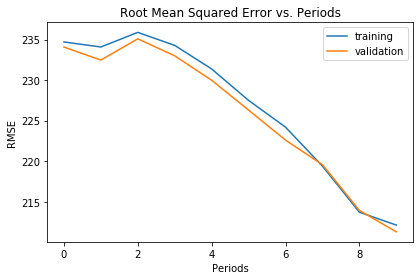

In [0]:
# Call the training model:
learning_rate = 0.15
steps = 100
batch_size = 100

calibration_data = train_model( learning_rate, steps, batch_size, training_examples=training_examples, training_targets=training_targets, validation_examples=validation_examples, validation_targets=validation_targets )

Task 5: Evaluate on Test Data

In [0]:
chtd = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_test.csv", sep=",")

test_examples = preprocess_features(chtd)
test_targets = preprocess_targets(chtd)

predict_training_input_fn = lambda : my_input_fn(training_examples, training_targets, shuffle=False, num_epochs=1)
training_predictions = calibration_data.predict(input_fn=predict_training_input_fn)
training_predictions = np.array([item['predictions'][0] for item in training_predictions])

predict_validation_input_fn = lambda : my_input_fn(validation_examples, validation_targets, shuffle=False, num_epochs=1)
validation_predictions = calibration_data.predict(input_fn=predict_validation_input_fn)
validation_predictions = np.array([item['predictions'][0] for item in validation_predictions])

predict_test_input_fn = lambda : my_input_fn(test_examples, test_targets, shuffle=False, num_epochs=1)
test_predictions = calibration_data.predict(input_fn=predict_test_input_fn)
test_predictions = np.array([item['predictions'][0] for item in test_predictions])

training_root_mean_squared_error = math.sqrt( metrics.mean_squared_error(training_predictions, training_targets) )
validation_root_mean_squared_error = math.sqrt( metrics.mean_squared_error(validation_predictions, validation_targets) )
test_root_mean_squared_error = math.sqrt( metrics.mean_squared_error(test_predictions, test_targets) )
# RMSE comparison between training, validation and test:
print(" RMSE on Training set: %0.2f" % (training_root_mean_squared_error))
print(" RMSE on Validation set: %0.2f" % (validation_root_mean_squared_error))
print(" RMSE on Test set: %0.2f" % (test_root_mean_squared_error))

 RMSE on Training set: 212.13
 RMSE on Validation set: 211.30
 RMSE on Test set: 211.96
